In [1]:
#Classification of XOR dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets

include("proposals.jl")
include("mnist.jl")
include("utils.jl");

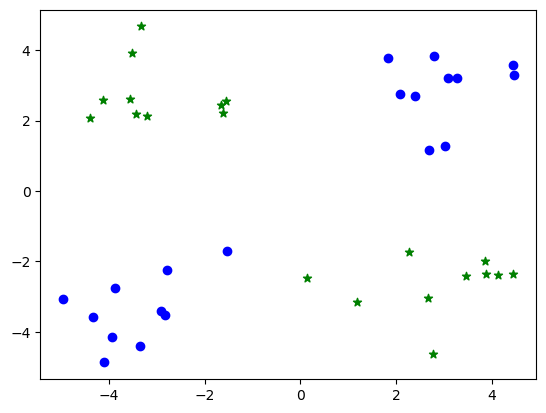

(2, 40)

In [220]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
c = 2
n = 10 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 1.0 #Mode variance (classifier)
bound = 3.0

#Network hyperparameters
α₁ = 1 #Input Weights, Biases Shape
β₁ = 0.1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = 0.1/2

#Node hyperparameters
k_range = 100 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δ_max = 1000;

x_raw, classes = real_data_classifier(Int(N/4), 4, bound, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y = classes

plot_data_classifier(x_raw,classes)
xt = transpose(x_raw)
size(xt)

In [221]:
#One-Hot Encode Y
yt = Flux.onehotbatch(y,[:1,:2]);

#Test Set
x_raw_test, classes_test = real_data_classifier(Int(N/4), 4, bound, σₐ);
xt_test = transpose(x_raw_test)
classes_test = [(i+1) % 2 + 1 for i in classes]
y_test = classes_test
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2]);

In [222]:
function softmax_(arr::AbstractArray)
    ex = mapslices(x -> exp.(0.01.*x),arr,dims=1)
    rows, cols = size(arr)
    val = similar(ex)
    for i in 1:cols
        s = sum(ex[:,i])
        for j in 1:rows
            val[j,i] = ex[j,i]/s
        end
    end
    return val
end;

#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    x = nn_out(x)
    
    return softmax_(x)
end;

In [223]:
@gen function classifier(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, c)
    output_array[c] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ##################################################
    #Adapted from BH: hyperparameter schedule - Apr 3#
    ##################################################
    
    #α₁ = 1 #Input Weights, Biases Shape
    #β₁ = 0.1 #Input Weights, Biases Scale/Rate
    #α₂ = 1 #Hidden & Output Weights Shape
    #β₂ = 0.1/k[1] #Scale Hyperparameter Based on Number of Nodes
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(c)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    
    #Logistic Classification Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        #println(score_vec)
        y[j] = @trace(categorical(score_vec), (:y,j))
    end
    
    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
println(best_trace[(:k,1)])
test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

-1261.7913996626016
47


21

In [224]:
include("proposals.jl")
obs[(:k,1)] = 2
(best_trace,) = generate(classifier, (xt,), obs)
new_trace,q = node_birth(best_trace)
display(reshape(best_trace[(:W,1)], best_trace[(:k,1)], d))
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
println(get_score(best_trace))
println(get_score(new_trace))

test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

println("q: $q")

2×2 Array{Float64,2}:
  2.61498   2.3784
 -0.503353  0.939725

3×2 Array{Float64,2}:
 -1.19132   4.08469
  2.61498   2.3784
 -0.503353  0.939725

-61.38203988721409
-116.02451271481307
Old trace Accuracy: 13
New trace Accuracy: 23
q: 18.25739814938233


In [225]:
include("proposals.jl")

println("Current k: $(best_trace[(:k,1)])")
new_trace2,q = node_death(new_trace)
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
display(reshape(new_trace2[(:W,1)], new_trace2[(:k,1)], d))
println(get_score(new_trace))
println(get_score(new_trace2))

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace2)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

println("q: $q")

3×2 Array{Float64,2}:
 -1.19132   4.08469
  2.61498   2.3784
 -0.503353  0.939725

2×2 Array{Float64,2}:
 -1.19132   4.08469
 -0.503353  0.939725

Current k: 2
-116.02451271481307
-101.38218437131941
Old trace Accuracy: 23
New trace Accuracy: 20
q: -18.873080184172288


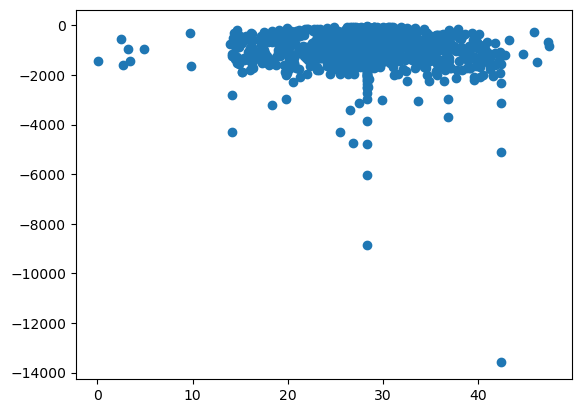

PyObject <matplotlib.collections.PathCollection object at 0x7f261d8780d0>

In [226]:
#Test Likelihood
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

scores = []
accs = []
traces = []
ks = []
for i = 1:1000
    (trace,) = generate(classifier, (xt,), obs)
    push!(ks,trace[(:k,1)])
    push!(scores,get_score(trace))
    push!(traces,trace)
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_acc = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
end

scatter(accs,scores)
#plt.ylim(-2000,0)
#println(ks)

In [228]:
#-------------
#Run Inference
#-------------

include("NUTS2.jl")
Δ_max = 1000
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
across_iters = 1
m = 1

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            #println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function node_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:across_iters
        trace_tilde = gibbs_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:across_iters
        (trace_star,) = nuts_parameters(trace_star)
        trace_star = gibbs_hyperparameters(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;
obs[(:k,1)] = 1

(trace,) = generate(classifier, (xt,), obs)
#trace = best_trace
starting_k = trace[(:k,1)]
println("Starting k: $starting_k")
flush(stdout)
traces = []

for i=1:1000
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Starting k: 1
1 : -62.59261698568916
********** Accepted: 2 **********
2 : -63.809140340521466
3 : -56.981291841823804
4 : -72.11057646904577
5 : -65.010592989769
6 : -66.2744256043905
********** Accepted: 3 **********
7 : -83.03628653927714
8 : -79.81298363170403
9 : -78.50037106316762
10 : -77.07877065973555
Epoch 10 A Acceptance Probability: 20.0 %
Epoch 10 W Acceptance Probability: 100.0 %
11 : -77.70605633027157
12 : -76.08824990218372
13 : -80.82353927683383
14 : -78.2371932575431
15 : -79.09116816871526


InterruptException: InterruptException:

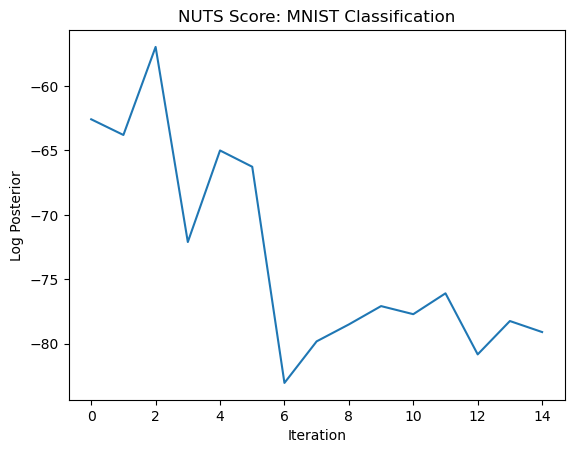

In [229]:
#Log Posterior Score Chart
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: MNIST Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

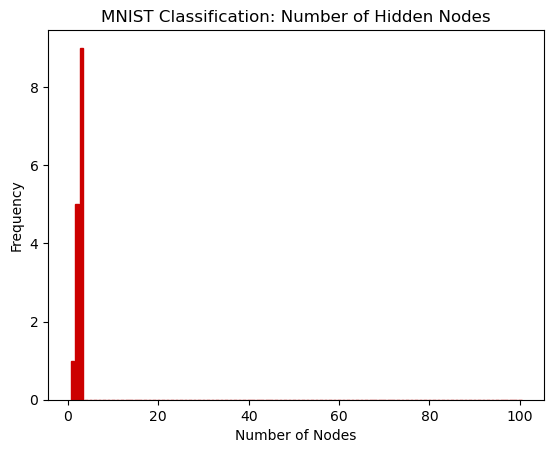

In [230]:
#Node Count Histogram

########################
#Bar Plot of l estimates
########################

ks = [traces[i][(:k,1)] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]

barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
#barlist[2].set_color([0.0,0.8,0.1])

plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency");

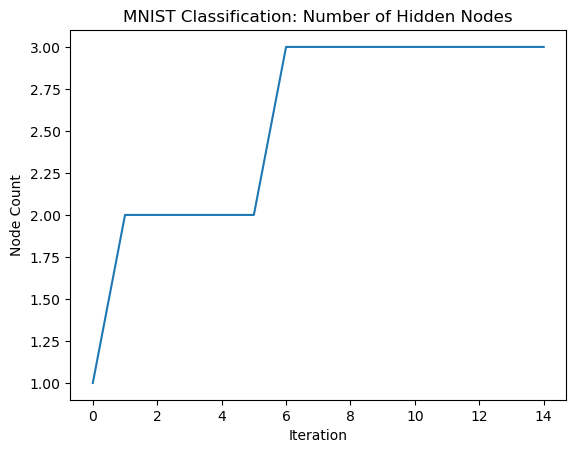

In [231]:
#Node Count Chart

plot([trace[(:k,1)] for trace in traces])
plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

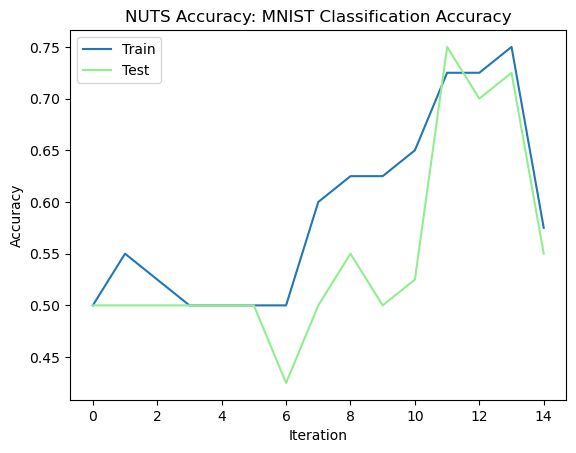

In [232]:
#Plot Training Accuracy
accs = []
accs2 = []
dists = []
dists2 = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    push!(dists,test_dist)
    
    trace = traces[i]
    test_labels = G(xt_test,trace)
    results = label_output(test_labels)
    test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
    test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs2,test_acc)
    push!(dists2,test_dist)
end

plot(accs,label="Train")
plot(accs2,label="Test",c="lightgreen")
plt.title("NUTS Accuracy: MNIST Classification Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend();

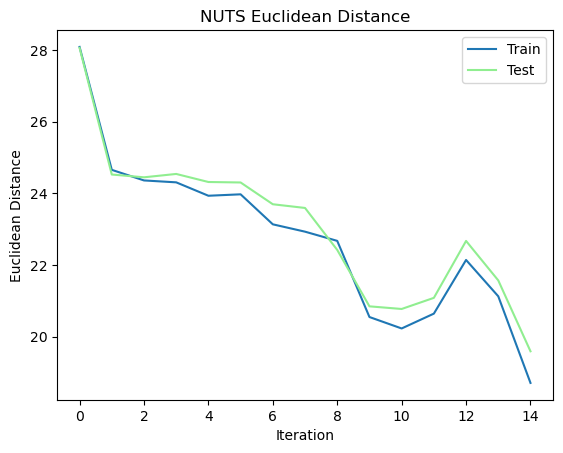

In [233]:
plot(dists,label="Train")
plot(dists2,label="Test",color="lightgreen")
plt.title("NUTS Euclidean Distance")
plt.xlabel("Iteration")
plt.ylabel("Euclidean Distance")
plt.legend();

In [234]:
#Marginalize Probabilities - Train Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])

25

In [235]:
#Marginalize Probabilities - Test Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt_test,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([yz[i] == guesses[i] for i=1:length(yz)])

20

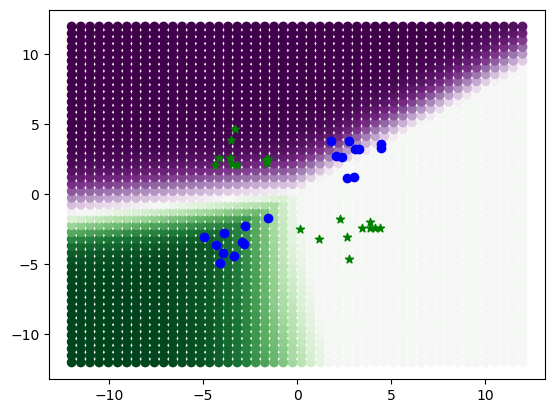

In [251]:
function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="PRGn")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=1, low=-12.0, high=12.0)
    d=2
    n=50
    starting_iter = 1
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((starting_iter,length(traces)))
        trace = traces[j]
        z = G(grid2,trace)[1,:]
        #display(z)
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)
plot_data_classifier(x_raw,classes)

In [213]:
weights = [trace[(:W,1)][1] for trace in traces]
plot(weights)
weights = [trace[(:W,1)][2] for trace in traces]
plot(weights)
weights = [trace[(:W,1)][3] for trace in traces]
plot(weights)
weights = [trace[(:W,1)][48] for trace in traces]
plot(weights)
weights = [trace[(:W,1)][57] for trace in traces]
plot(weights)
weights = [trace[(:W,1)][58] for trace in traces]
plot(weights)
weights = [trace[(:W,1)][59] for trace in traces]
plot(weights)
weights = [trace[(:W,1)][60] for trace in traces]
plot(weights)

BoundsError: BoundsError: attempt to access 2-element Array{Float64,1} at index [3]

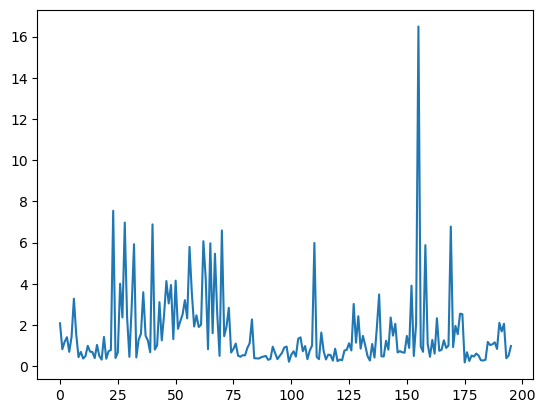

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb219dfa150>

In [51]:
plot([1/trace[(:τᵦ,2)] for trace in traces])